In [1]:
import numpy as np
import pandas as pd
import os
import random
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras_tuner import Hyperband
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
DATA_PATH = './data/images'
CNN_IMAGE_RESULTS = './results/cnn/images'
CNN_HISTORY_RESULTS = './results/cnn/history'
CNN_REPORT_RESULTS = './results/cnn/reports'
CNN_MODEL_RESULTS = './results/cnn/models'

TRAIN_DIRECTORY = 'train'
VALIDATION_DIRECTORY = 'val'
TEST_DIRECTORY = 'test'

SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
CATEGORY_DIRECTORIES = ['Chickenpox', 'Cowpox', 'Healthy', 'HFMD', 'Measles', 'Monkeypox']

In [3]:
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        total = 0
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"============ {dataset_type} dataset ===========")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg','jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
            total += len(images)
        print(f"Total image count: {total}")
        print("")

In [4]:
count_images(DATA_PATH)

============ train dataset ===========
Number of images in Cowpox: 792
Number of images in Healthy: 1000
Number of images in HFMD: 1000
Number of images in Measles: 660
Number of images in Chickenpox: 900
Number of images in Monkeypox: 1000
Total image count: 5352

============ test dataset ===========
Number of images in Cowpox: 99
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 83
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 582

============ val dataset ===========
Number of images in Cowpox: 99
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 82
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 581



In [5]:
def load_images_to_df(base_path, dataset_type):
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([file_paths, labels], axis=1)

    samples = []
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label']==record])
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    return image_df

In [6]:
df_train = load_images_to_df(DATA_PATH, TRAIN_DIRECTORY)
df_train.head(10)

,Path,Label
0,data/images/train/Chickenpox/CHP_28_01_9.jpg,Chickenpox
1,data/images/train/Healthy/HEALTHY_100_01_7.jpg,Healthy
2,data/images/train/Cowpox/CWP_41_02_11.jpg,Cowpox
3,data/images/train/Chickenpox/CHP_41_01_7.jpg,Chickenpox
4,data/images/train/Healthy/HEALTHY_100_01.jpg,Healthy
5,data/images/train/Cowpox/CWP_10_01_1.jpg,Cowpox
6,data/images/train/Cowpox/CWP_04_01_11.jpg,Cowpox
7,data/images/train/Measles/MSL_01_01_4.jpg,Measles
8,data/images/train/Monkeypox/MKP_138_02_ORIGINA...,Monkeypox
9,data/images/train/Measles/MSL_16_01_ORIGINAL.jpg,Measles


In [7]:
df_val = load_images_to_df(DATA_PATH, VALIDATION_DIRECTORY)
df_val.head(10)

,Path,Label
0,data/images/val/Monkeypox/MKP_108_03_9.jpg,Monkeypox
1,data/images/val/HFMD/HFMD_142_01_8.jpg,HFMD
2,data/images/val/Healthy/HEALTHY_11_01_13.jpg,Healthy
3,data/images/val/Chickenpox/CHP_56_01_13.jpg,Chickenpox
4,data/images/val/Chickenpox/CHP_47_01_2.jpg,Chickenpox
5,data/images/val/HFMD/HFMD_126_01_2.jpg,HFMD
6,data/images/val/Chickenpox/CHP_26_01_5.jpg,Chickenpox
7,data/images/val/Healthy/HEALTHY_102_01.jpg,Healthy
8,data/images/val/HFMD/HFMD_107_01_10.jpg,HFMD
9,data/images/val/Monkeypox/MKP_10_01_5.jpg,Monkeypox


In [8]:
df_test = load_images_to_df(DATA_PATH, TEST_DIRECTORY)
df_test.head(10)

,Path,Label
0,data/images/test/Monkeypox/MKP_06_02_7.jpg,Monkeypox
1,data/images/test/HFMD/HFMD_08_01_ORIGINAL.jpg,HFMD
2,data/images/test/Healthy/HEALTHY_31_01_9.jpg,Healthy
3,data/images/test/Chickenpox/CHP_06_02_9.jpg,Chickenpox
4,data/images/test/Chickenpox/CHP_46_01_1.jpg,Chickenpox
5,data/images/test/HFMD/HFMD_104_01.jpg,HFMD
6,data/images/test/Chickenpox/CHP_09_01_12.jpg,Chickenpox
7,data/images/test/Healthy/HEALTHY_35_01_9.jpg,Healthy
8,data/images/test/Measles/MSL_20_01_9.jpg,Measles
9,data/images/test/Measles/MSL_01_02_10.jpg,Measles


In [9]:
def pie_plot_from_df(df, title):
    pie = df["Label"].value_counts()
    pie.plot(kind="pie", autopct="%1.2f%%")
    plt.ylabel("")
    plt.xlabel(title)
    plt.show()

In [10]:
def show_images_from_df(df, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8), subplot_kw={"xticks":[], "yticks":[]})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Path[i], -1))
        ax.set_title(df.Label[i])
    plt.tight_layout()
    plt.show()

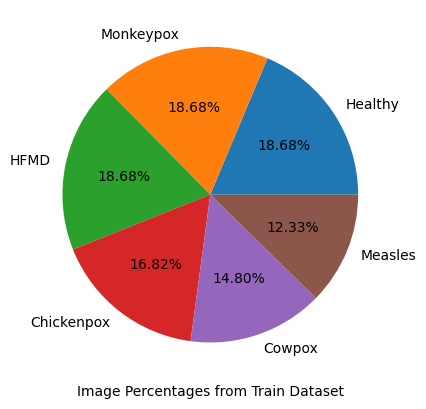

In [11]:
pie_plot_from_df(df_train, "Image Percentages from Train Dataset")

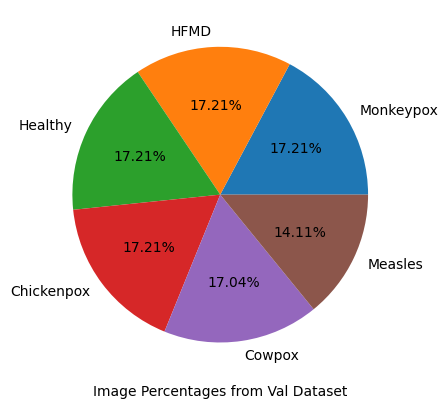

In [12]:
pie_plot_from_df(df_val, "Image Percentages from Val Dataset")

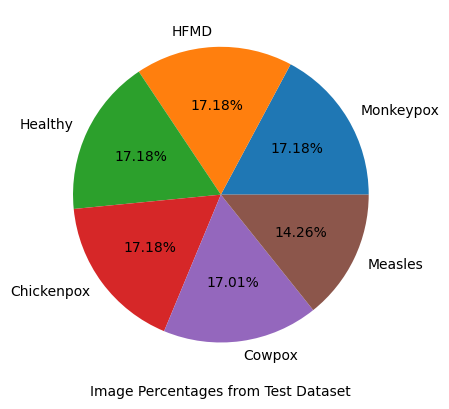

In [13]:
pie_plot_from_df(df_test, "Image Percentages from Test Dataset")

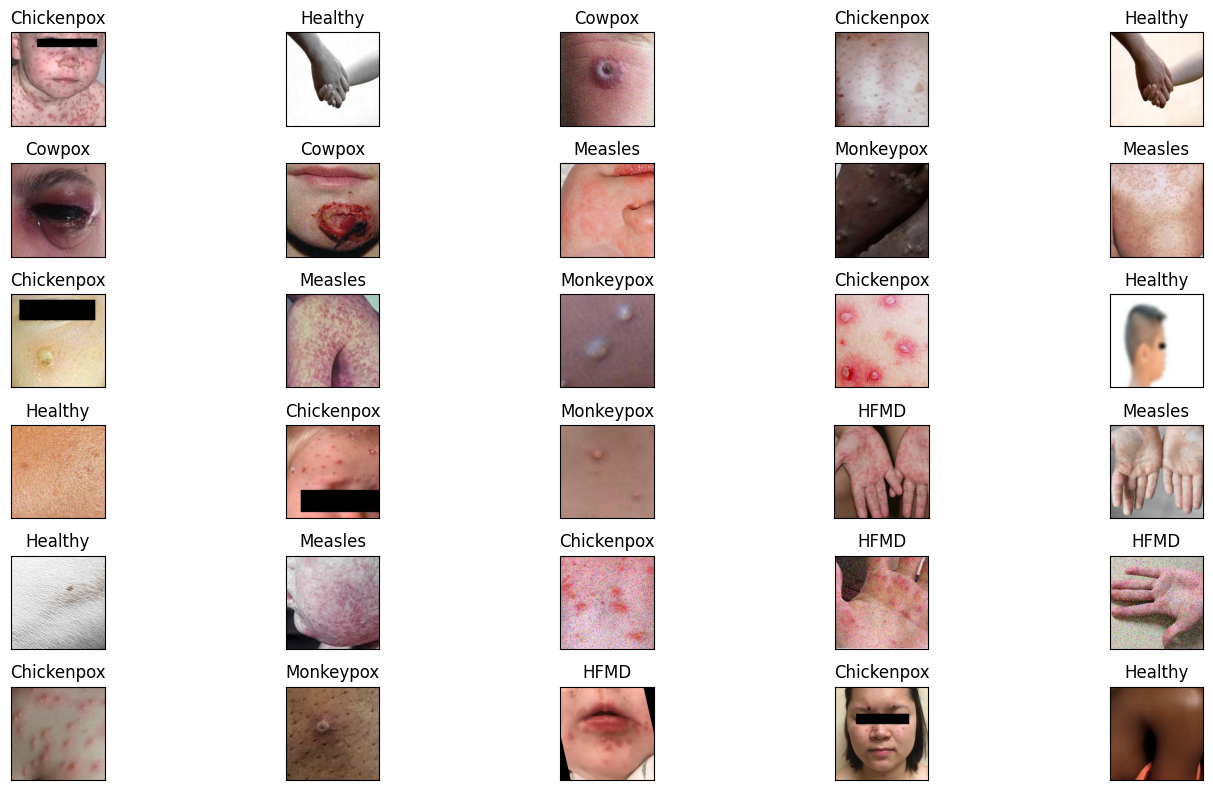

In [14]:
show_images_from_df(df_train, 6, 5)

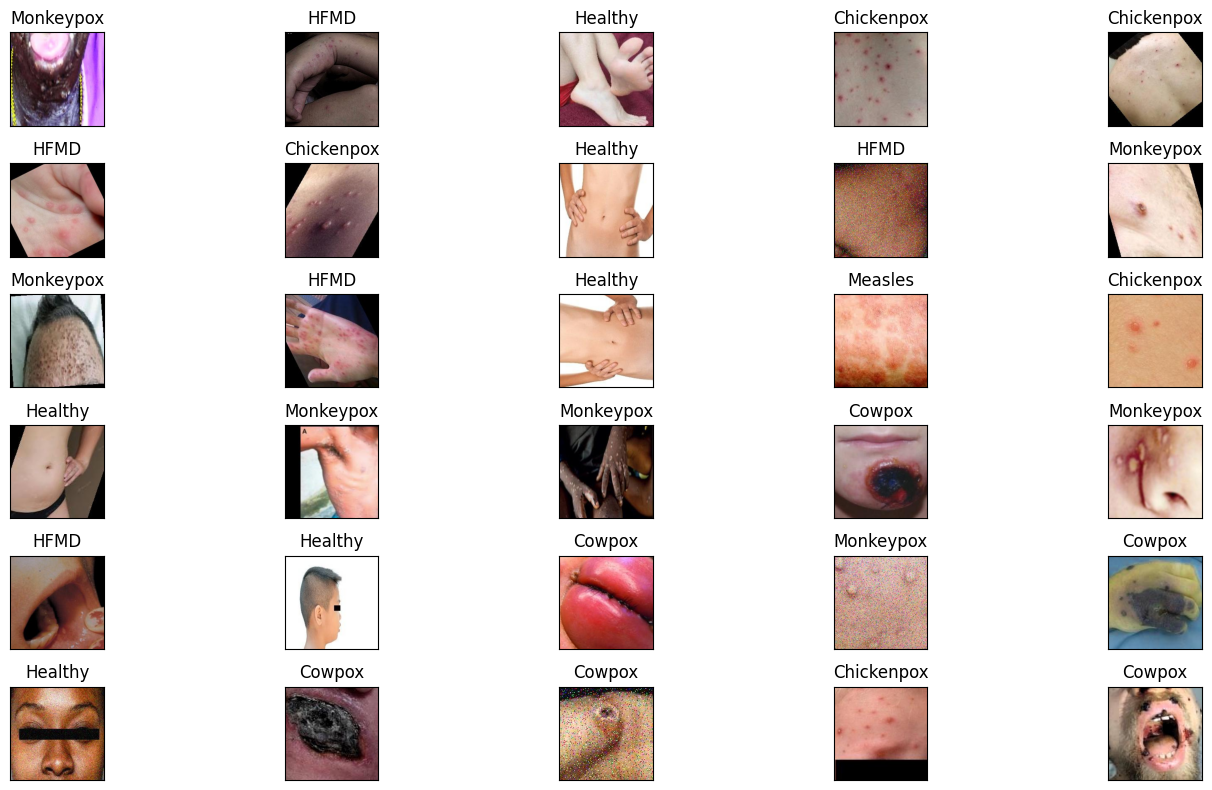

In [15]:
show_images_from_df(df_val, 6, 5)

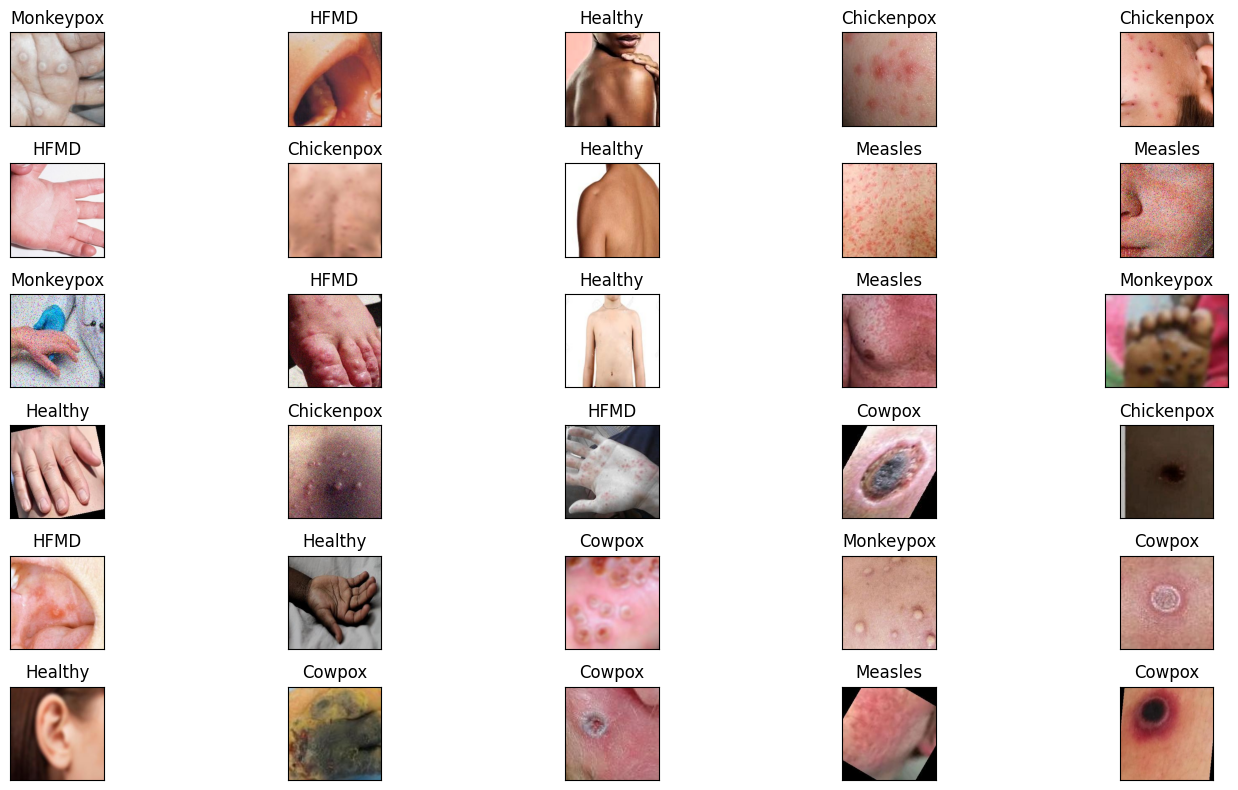

In [16]:
show_images_from_df(df_test, 6, 5)

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    fill_mode="nearest",
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
)

In [18]:
def create_dataset(generator, df, subset):
    images = generator.flow_from_dataframe(
        dataframe=df,
        x_col='Path', 
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42)
    print(f"{subset} class indices: {images.class_indices}\n")
    return images

In [19]:
train_dataset = create_dataset(train_generator, df_train, TRAIN_DIRECTORY)
val_dataset = create_dataset(val_generator, df_val, VALIDATION_DIRECTORY)
test_dataset = create_dataset(test_generator, df_test, TEST_DIRECTORY)

Found 5352 validated image filenames belonging to 6 classes.
train class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}

Found 581 validated image filenames belonging to 6 classes.
val class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}

Found 582 validated image filenames belonging to 6 classes.
test class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}



## Model Based on Random Values

2025-01-26 11:59:34.863065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-01-26 11:59:34.863098: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-26 11:59:34.863102: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-26 11:59:34.863294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-26 11:59:34.863322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87910968/87910968 [==============================] - 8s 0us/step


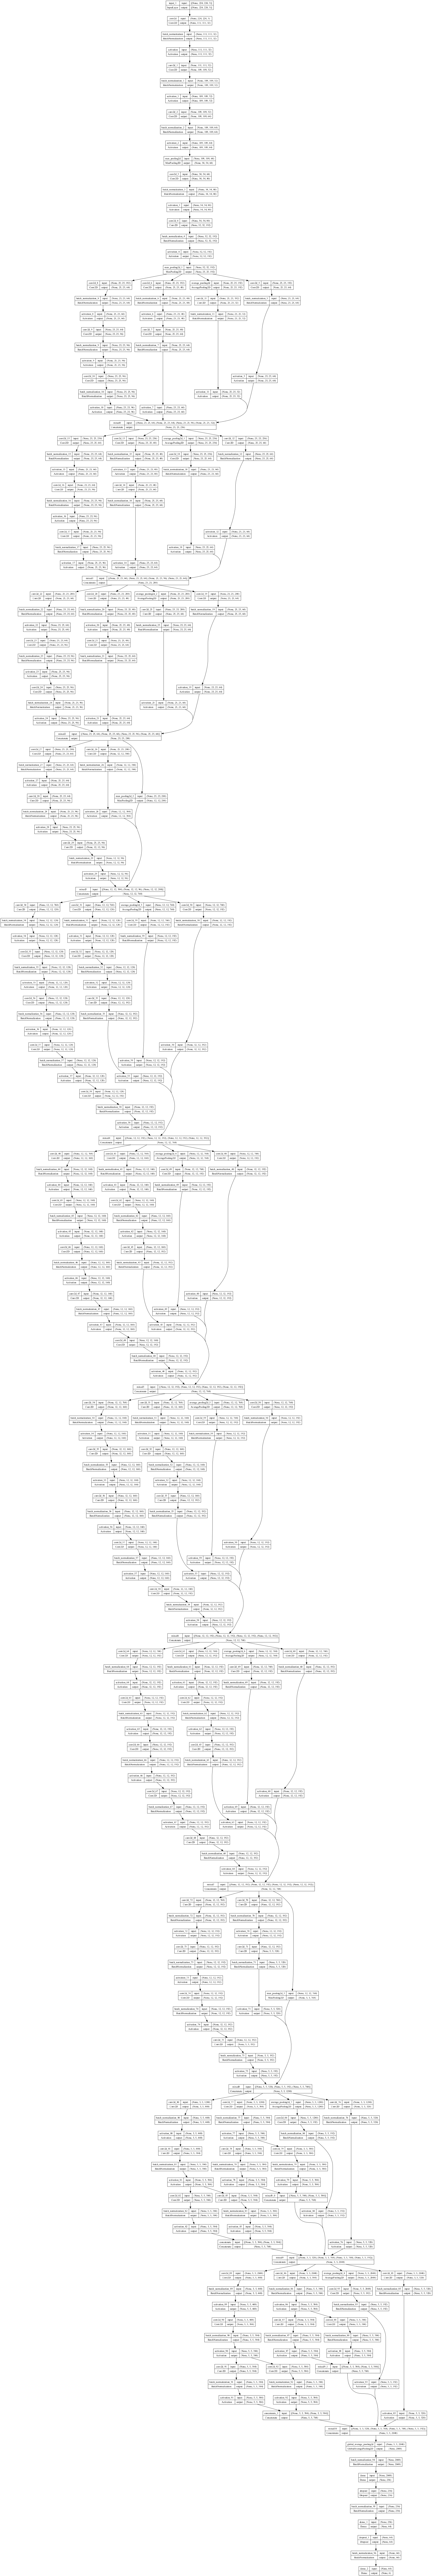

In [20]:
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

inputs = base_model.input

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
outputs = Dense(len(CATEGORY_DIRECTORIES), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/inception_v3_model_summary.png", show_shapes=True, dpi=50)

In [21]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min",
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=110,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/110


2025-01-26 11:59:47.811918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 71/168 [===========>..................] - ETA: 18s - loss: 1.0769 - categorical_accuracy: 0.6081

In [ ]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/inception_v3_accuracy_plot.png")

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/inception_v3_loss_plot.png")

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/inception_v3_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/inception_v3_history.csv"
history_df.to_csv(history_csv)

In [ ]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/inception_v3_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/inception_v3_confusion_matrix.png'
plt.savefig(heatmap_file)

In [ ]:
model.save(f"{CNN_MODEL_RESULTS}/inception_v3.h5")

In [ ]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices.items()}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {label} | Predicted: {predicted_class}")

## Hyper-parameter Tuned Model

In [ ]:
def build_model_with_hp(hp, base_model, num_classes):
    inputs = base_model.input

    x = base_model.output

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(units=hp.Int("dense_1_units", min_value=128, max_value=512, step=32), activation="relu")(x)
    x = Dropout(rate=hp.Choice("dropout_rate_1", values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]))(x)

    x = BatchNormalization()(x)
    x = Dense(units=hp.Int('dense_2_units', min_value=32, max_value=512, step=16), activation='relu')(x)

    x = Dropout(rate=hp.Choice('dropout_rate_2', values=[0.2,0.3,0.4,0.5,0.6,0.7]))(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

In [ ]:
def perform_hyperparameter_tuning(model_name, base_model_func, train_dataset, val_dataset, num_classes, max_epochs=110, max_trials=5):
    base_model = base_model_func(weights="imagenet", include_top=False, input_shape=(224,224,3))

    # tuner = Hyperband(
    #     lambda hp: build_model_with_hp(hp, base_model, num_classes),
    #     objective="categorical_accuracy",
    #     max_epochs=max_epochs,
    #     factor=3,
    #     directory="hyperparameter_tuning",
    #     project_name=model_name
    # )

    tuner = RandomSearch(
        lambda hp: build_model_with_hp(hp, base_model, num_classes),
        objective="val_categorical_accuracy",
        max_trials=max_trials,  # Restrict to 5 trials
        executions_per_trial=1,
        directory="hyperparameter_tuning",
        project_name=model_name
    )

    tuner.search(train_dataset, validation_data=val_dataset, epochs=max_epochs, callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    Best hyperparameters:
    - Units in Dense Layer 1: {best_hps.get('dense_1_units')}
    - Dropout Rate for Layer 1: {best_hps.get('dropout_rate_1')}
    - Units in Dense Layer 2: {best_hps.get('dense_1_units')}
    - Dropout Rate for Layer 2: {best_hps.get('dropout_rate_2')}
    - Learning Rate: {best_hps.get('learning_rate')}
    """)
    
    return tuner

In [ ]:
tuner = perform_hyperparameter_tuning("InceptionV3", InceptionV3, train_dataset, val_dataset, len(CATEGORY_DIRECTORIES))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = build_model_with_hp(best_hps, base_model, len(CATEGORY_DIRECTORIES))
tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/inception_v3_hp_model_summary.png", show_shapes=True, dpi=50)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    epochs=110,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)],
    class_weight=class_weights
)

In [ ]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/inception_v3__hp_accuracy_plot.png")

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/inception_v3_hp_loss_plot.png")

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/inception_v3_hp_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/inception_v3_hp_history.csv"
history_df.to_csv(history_csv)

In [ ]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/inception_v3_hp_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/inception_v3_hp_confusion_matrix.png'
plt.savefig(heatmap_file)

In [ ]:
model.save(f"{CNN_MODEL_RESULTS}/inception_v3_hp.h5")

In [ ]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices.items()}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {label} | Predicted: {predicted_class}")